## Imports

In [17]:
import json
import re
from pathlib import Path
from typing import Dict, Any, List, Optional
import hashlib
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Setup + load data

In [3]:
pd.set_option('display.max_colwidth', 120)

DATA_PATH = Path("data.json")

def load_jsonl(path: Path) -> pd.DataFrame:
    rows = []
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

def load_json_any(path: Path) -> pd.DataFrame:
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        head = f.read(2048)
    if head.lstrip().startswith("["):
        data = json.loads(path.read_text(encoding="utf-8", errors="ignore"))
        return pd.DataFrame(data)
    return load_jsonl(path)

df = load_json_any(DATA_PATH)

print("Rows:", len(df))
print("Columns:", list(df.columns))
df.head(5)

Rows: 838
Columns: ['Folder', 'Image Name', 'Text', 'Label']


,Folder,Image Name,Text,Label
0,stiri_fabricate_img,a.xZU2pG9ffSpCwPyETxI_X.xA68-text.jpg,Îmbătrânirea populației este o provocare cunoscută. Și Fondul Monetar Internațional îi acordă o analiză amplă în fie...,0
1,stiri_fabricate_img,a0pjxJ5MjHAdqhSRecpnfgk6ZaJ0-text.jpg,"ISTERIA CU CORONAVIRUSUL ÎN ROMÂNIA A AVUT CA SCOP LEGALIZAREA ABUZIVĂ A VACCINULUI OBLIGATORIU, CEL PUȚIN ÎN ROMÂNI...",0
2,stiri_fabricate_img,a0xavbcvUC1rQPuwbL.Y.BWVRsS0-text.jpg,"Fondatorul miliardar al Microsoft, Bill Gates - 64 de ani - a fost arestat astăzi, 12.05.2020, de FBI sub acuzația ...",0
3,stiri_fabricate_img,a1.oOuWqgURv38xfi3ytnImiLX64-text.jpg,În timp ce lumea rămâne încremenită de decizia Statelor Unite de a sista și evalua finanțarea Organizației Mondiale ...,0
4,stiri_fabricate_img,a1G7mIc4kfywvR_dt9175bAcrnvC-text.jpg,"Când l-am văzut pe Iohannis, în timpul vizitelor sale pe la Bruxelles, că, în loc să dea mâna cu ceilalți oficiali, ...",0


## Standardize column names

In [4]:
df = df.rename(columns={c: c.strip().lower().replace(" ", "_") for c in df.columns})

required = ["text", "label"]
missing_required = [c for c in required if c not in df.columns]
if missing_required:
    raise ValueError(f"Missing required columns: {missing_required}. Found columns: {list(df.columns)}")

df["label"] = pd.to_numeric(df["label"], errors="coerce").astype("Int64")
df["text"] = df["text"].fillna("").astype(str)

df.isna().sum().sort_values(ascending=False).head(20)

folder        0
image_name    0
text          0
label         0
dtype: int64

## Class balance

In [5]:
label_counts = df["label"].value_counts(dropna=False).sort_index()
label_counts

label
0    120
1     78
2    157
3    308
4    175
Name: count, dtype: Int64

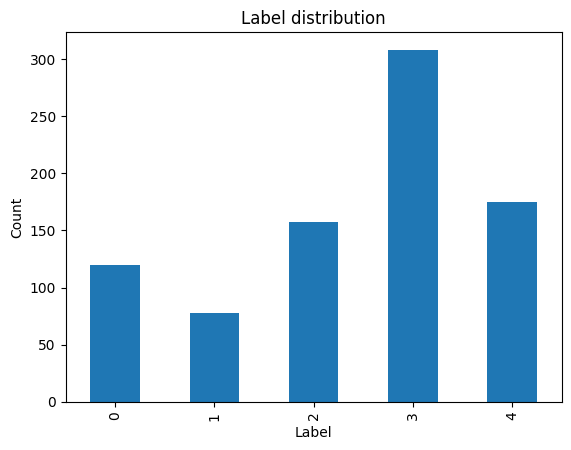

In [6]:
plt.figure()
label_counts.plot(kind="bar")
plt.title("Label distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

folder
stiri_reale_img              308
stiri_satirice_img           175
stiri_propagandistice_img    157
stiri_fabricate_img          120
stiri_plauzibile_img          78
Name: count, dtype: int64

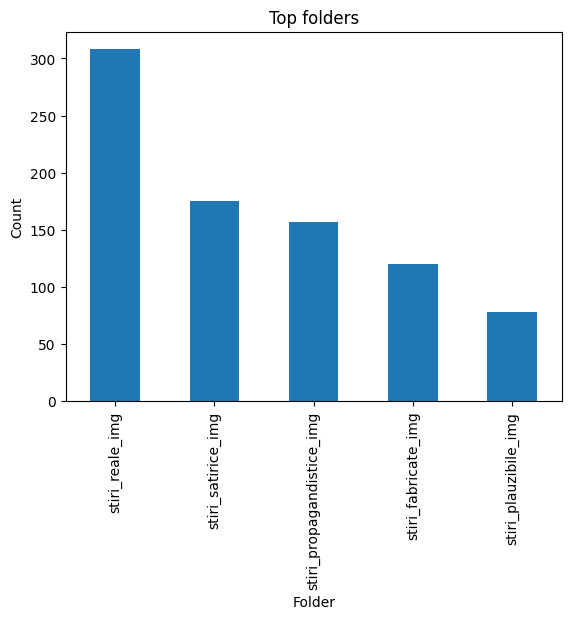

In [7]:
if "folder" in df.columns:
    folder_counts = df["folder"].fillna("NA").value_counts().head(30)
    display(folder_counts)
    plt.figure()
    folder_counts.plot(kind="bar")
    plt.title("Top folders")
    plt.xlabel("Folder")
    plt.ylabel("Count")
    plt.show()

## Text length stats

In [9]:
def safe_div(a: float, b: float) -> float:
    return float(a) / float(b) if b else 0.0

def compute_text_features(s: str) -> Dict[str, float]:
    s = s or ""
    n = len(s)
    words = re.findall(r"\S+", s)
    n_words = len(words)
    n_upper = sum(1 for ch in s if ch.isalpha() and ch.isupper())
    n_alpha = sum(1 for ch in s if ch.isalpha())
    n_digits = sum(1 for ch in s if ch.isdigit())
    n_punct = sum(1 for ch in s if re.match(r'[.,;:!?()\[\]{}\-\—"\'“”‘’…]', ch))
    return {
        "char_len": n,
        "word_count": n_words,
        "avg_word_len": safe_div(sum(len(w) for w in words), n_words),
        "upper_ratio": safe_div(n_upper, n_alpha),
        "digit_ratio": safe_div(n_digits, n),
        "punct_ratio": safe_div(n_punct, n),
        "has_newlines": int("\n" in s),
    }

feat_df = df["text"].apply(compute_text_features).apply(pd.Series)
df_feat = pd.concat([df, feat_df], axis=1)

df_feat[["char_len","word_count","avg_word_len","upper_ratio","digit_ratio","punct_ratio"]].describe(percentiles=[0.5,0.9,0.95,0.99])

,char_len,word_count,avg_word_len,upper_ratio,digit_ratio,punct_ratio
count,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000
mean,2815.621718,436.844869,5.351521,0.035542,0.008780,0.028695
std,2931.481216,449.680215,0.493140,0.022578,0.010277,0.008117
min,27.000000,3.000000,3.769231,0.007338,0.000000,0.009247
50%,1842.000000,292.000000,5.335249,0.031726,0.005492,0.027202
90%,6062.400000,933.800000,5.927253,0.054670,0.019469,0.040123
95%,8565.300000,1339.750000,6.070017,0.065360,0.027499,0.045006
99%,15163.410000,2371.480000,6.539111,0.108280,0.048316,0.052897
max,21051.000000,3222.000000,8.000000,0.377982,0.084765,0.067010


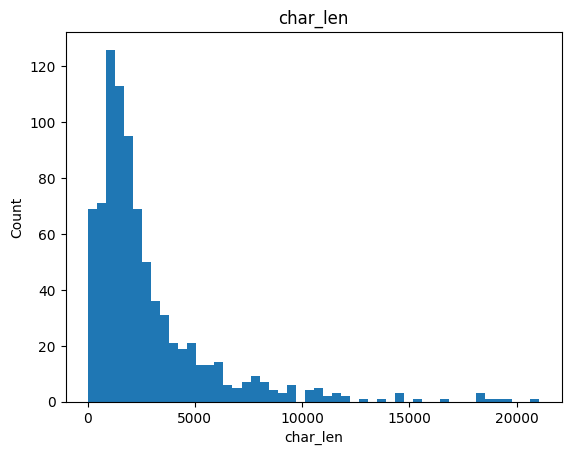

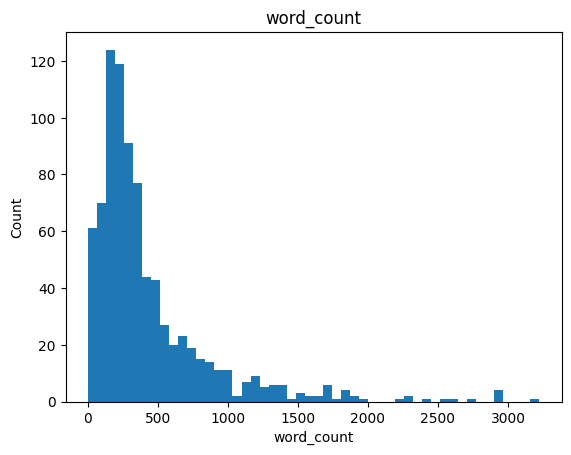

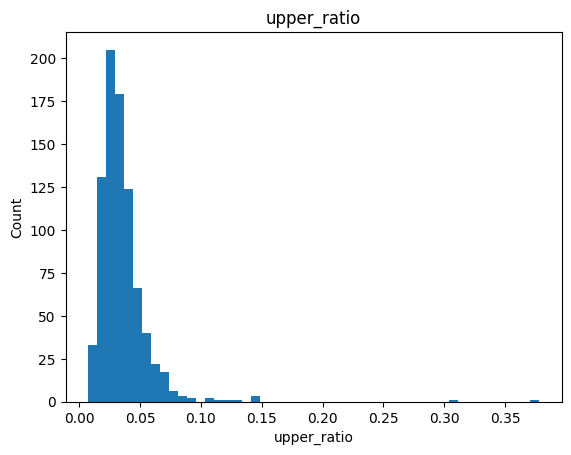

In [10]:
for col in ["char_len", "word_count", "upper_ratio"]:
    plt.figure()
    df_feat[col].plot(kind="hist", bins=50)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

In [11]:
print("Shortest texts:")
display(df_feat.sort_values("char_len").head(5)[["folder","image_name","label","char_len","text"]])

print("Longest texts:")
display(df_feat.sort_values("char_len", ascending=False).head(3)[["folder","image_name","label","char_len","text"]])

Shortest texts:


,folder,image_name,label,char_len,text
728,stiri_satirice_img,aH3AugrpiHAwf4EP8dnFqdJT5on8-satirice_vaccin_344.jpg,4,27.0,#davai-vaccin\n\n@Daniel Ioan
726,stiri_satirice_img,agmL6ljERy0xRfQuWDoyYiM7dr5O-satirice_vaccin_343.jpg,4,87.0,Au apărut imagini cu o fiolă din vaccinul rusesc!\n\nSe administrează intracranian.\n@A.Go
729,stiri_satirice_img,ah6cRtygsHsA_5zIKsooF0P9kjoe-satirice_microchip_50.jpg,4,108.0,"Priviți ce a putut să-i facă termoscannerul Brigittei Sfăt!\n\nPractic, i-a băgat vreo 5000 de cipuri în buze."
749,stiri_satirice_img,ak6sidsJ6YnxplVqhSzC6Bpjq2gi-satirice_vaccin_336.jpg,4,116.0,Omenirea răsuflă ușurată: S-a descoperit antidotul la vaccinul rusesc împotriva Covidului!\n\nVesta antiglonț.\n@calcar
746,stiri_satirice_img,aJRrSxrZpBYAv4iCT36XJCzzb1yu-satirice_microchip_49.jpg,4,119.0,"#cip-avem-baetzi\n\n@Sandu P.\nÎnainte de mine l-a mai folosit o bătrânică, însă doar pe acasă, că la biserică era î..."


Longest texts:


,folder,image_name,label,char_len,text
27,stiri_fabricate_img,aBDaj4XdEKoLt4PCV4LQ_Vfnlf8e-text.jpg,0,21051.0,"Vă prezentăm în continuare un studiu esenţial (pentru înţelegerea ceea ce se petrece în lume), lucid şi documentat a..."
84,stiri_fabricate_img,aPaKqkqGSg1ZtbL1NLHIiBABoYaa-text.jpg,0,19687.0,"Intrați pe poarta strâmtă; căci largă este poarta și largă este calea care duce la distrugere, și mulți sunt cei car..."
119,stiri_fabricate_img,a_Sq10s5XHBWedHiywl_yUq3xfzG-text.jpg,0,18975.0,"Virusul teoretic și imaginar cunoscut sub numele de SARS-CoV-2, un concept folosit de controlorii NOM (Noua Ordine M..."


## Duplicates

In [12]:
print("Exact duplicate texts:", df_feat["text"].duplicated().sum())

if "image_name" in df_feat.columns:
    print("Duplicate image_name:", df_feat["image_name"].duplicated().sum())

if df_feat["text"].duplicated().sum() > 0:
    dups = df_feat[df_feat["text"].duplicated(keep=False)].sort_values("text").head(10)
    display(dups[["folder","image_name","label","char_len","text"]])

Exact duplicate texts: 0
Duplicate image_name: 0


## Token stats + n-grams

In [13]:
def top_ngrams(texts: List[str], ngram_range=(1,1), top_k=30, min_df=3):
    vec = CountVectorizer(
        lowercase=True,
        token_pattern=r"(?u)\b[\wăâîșțĂÂÎȘȚ]{2,}\b",
        ngram_range=ngram_range,
        min_df=min_df,
    )
    X = vec.fit_transform(texts)
    counts = X.sum(axis=0).A1
    vocab = vec.get_feature_names_out()
    top_idx = counts.argsort()[::-1][:top_k]
    return pd.DataFrame({"ngram": vocab[top_idx], "count": counts[top_idx]})

display(top_ngrams(df_feat["text"].tolist(), (1,1), top_k=30, min_df=5))
display(top_ngrams(df_feat["text"].tolist(), (2,2), top_k=30, min_df=5))

,ngram,count
0,de,19377
1,în,10288
2,și,6686
3,la,5818
4,care,4761
5,să,4720
6,cu,4351
7,că,4161
8,din,4011
9,pentru,4005


,ngram,count
0,covid 19,1085
1,de la,1033
2,au fost,643
3,în care,483
4,care au,453
5,pe care,450
6,de vaccinare,445
7,ar fi,413
8,să fie,408
9,să se,407


In [14]:
unique_labels = sorted([x for x in df_feat["label"].dropna().unique()])
if len(unique_labels) >= 2:
    for lab in unique_labels:
        subset = df_feat[df_feat["label"] == lab]
        if len(subset) < 20:
            continue
        print(f"\n=== Label {lab} (n={len(subset)}) top unigrams ===")
        display(top_ngrams(subset["text"].tolist(), (1,1), top_k=20, min_df=3))
else:
    print("Only one label present (or labels missing). Per-label analysis skipped.")


=== Label 0 (n=120) top unigrams ===


,ngram,count
0,de,4332
1,în,2321
2,și,2203
3,care,1282
4,la,1249
5,nu,1089
6,să,1072
7,cu,1055
8,pentru,1000
9,este,993



=== Label 1 (n=78) top unigrams ===


,ngram,count
0,de,2735
1,în,1428
2,și,987
3,la,784
4,să,717
5,pentru,606
6,din,603
7,care,585
8,cu,561
9,mai,513



=== Label 2 (n=157) top unigrams ===


,ngram,count
0,de,4338
1,în,2321
2,și,1803
3,la,1422
4,care,1256
5,că,1165
6,să,1115
7,nu,991
8,cu,991
9,din,895



=== Label 3 (n=308) top unigrams ===


,ngram,count
0,de,7010
1,în,3765
2,la,1983
3,şi,1648
4,din,1440
5,cu,1434
6,care,1405
7,pentru,1397
8,să,1361
9,și,1348



=== Label 4 (n=175) top unigrams ===


,ngram,count
0,de,962
1,să,455
2,în,453
3,la,380
4,că,346
5,și,345
6,nu,339
7,cu,310
8,pe,290
9,un,244


## TF-IDF per label

In [15]:
def top_tfidf_terms_per_label(df_in: pd.DataFrame, label_col="label", text_col="text", top_k=25, min_df=3):
    labels = sorted([x for x in df_in[label_col].dropna().unique()])
    if len(labels) < 2:
        return None

    vec = TfidfVectorizer(
        lowercase=True,
        token_pattern=r"(?u)\b[\wăâîșțĂÂÎȘȚ]{2,}\b",
        min_df=min_df,
        ngram_range=(1,2),
        max_features=50000,
    )
    X = vec.fit_transform(df_in[text_col].tolist())
    vocab = vec.get_feature_names_out()

    out = {}
    for lab in labels:
        idx = (df_in[label_col] == lab).fillna(False).to_numpy()
        if idx.sum() < 20:
            continue
        mean_vec = X[idx].mean(axis=0).A1
        top_idx = mean_vec.argsort()[::-1][:top_k]
        out[int(lab)] = pd.DataFrame({"term": vocab[top_idx], "avg_tfidf": mean_vec[top_idx]})
    return out

tfidf_top = top_tfidf_terms_per_label(df_feat)
if tfidf_top is None:
    print("Need at least 2 labels for TF-IDF per class.")
else:
    for lab, table in tfidf_top.items():
        print(f"\n=== Label {lab} top TF-IDF terms ===")
        display(table)


=== Label 0 top TF-IDF terms ===


,term,avg_tfidf
0,de,0.194279
1,și,0.123456
2,în,0.104269
3,care,0.062332
4,la,0.059418
5,nu,0.057680
6,este,0.057325
7,să,0.055932
8,cu,0.052742
9,pentru,0.049118



=== Label 1 top TF-IDF terms ===


,term,avg_tfidf
0,de,0.220567
1,în,0.119537
2,și,0.104795
3,la,0.066488
4,să,0.062594
5,şi,0.056990
6,pentru,0.055586
7,din,0.051972
8,care,0.049682
9,cu,0.049222



=== Label 2 top TF-IDF terms ===


,term,avg_tfidf
0,de,0.181964
1,și,0.104458
2,în,0.102327
3,la,0.063875
4,care,0.057951
5,că,0.057801
6,să,0.055976
7,nu,0.051784
8,este,0.043732
9,cu,0.043607



=== Label 3 top TF-IDF terms ===


,term,avg_tfidf
0,de,0.182063
1,în,0.101282
2,şi,0.078333
3,la,0.053089
4,și,0.045195
5,pentru,0.043023
6,care,0.040995
7,cu,0.040512
8,din,0.040475
9,să,0.040234



=== Label 4 top TF-IDF terms ===


,term,avg_tfidf
0,de,0.095487
1,să,0.052535
2,în,0.048309
3,și,0.046367
4,nu,0.045835
5,la,0.043260
6,şi,0.040732
7,că,0.040102
8,pe,0.036931
9,cu,0.036771


## Build final CSV

In [16]:
FOLDER_TO_LABEL = {
    "stiri_reale_img": "REAL",
    "stiri_plauzibile_img": "PLAUSIBLE",
    "stiri_satirice_img": "SATIRE",
    "stiri_propagandistice_img": "PROPAGANDA",
    "stiri_fabricate_img": "FABRICATED",
}

FALSE_CLASSES = {
    "SATIRE",
    "PROPAGANDA",
    "FABRICATED",
}

def map_label(folder: str) -> str:
    return FOLDER_TO_LABEL.get(folder, "UNKNOWN")

def map_label_group(label: str) -> str:
    if label in FALSE_CLASSES:
        return "FAKE"
    if label in ("REAL", "PLAUSIBLE"):
        return "REAL"
    return "OTHER"

In [18]:
df_final = df_feat.copy()

df_final["id"] = df_final.apply(
    lambda r: hashlib.sha1(
        f"{r.get('folder','')}|{r.get('image_name','')}|{r.get('text','')}".encode("utf-8")
    ).hexdigest(),
    axis=1
)

df_final["label"] = df_final["folder"].apply(map_label)
df_final["label_group"] = df_final["label"].apply(map_label_group)

df_final["source"] = "ocr_images"
df_final["text_len"] = df_final["text"].apply(len)

FINAL_COLS = [
    "id",
    "folder",
    "label",
    "label_group",
    "text",
    "text_len",
    "source",
]

df_final = df_final[FINAL_COLS].copy()

df_final.head()

,id,folder,label,label_group,text,text_len,source
0,fdade84368ba95bdb707aba7c26357e311158294,stiri_fabricate_img,FABRICATED,FAKE,Îmbătrânirea populației este o provocare cunoscută. Și Fondul Monetar Internațional îi acordă o analiză amplă în fie...,4796,ocr_images
1,d08d84ab9389be37748d6bab5aebfe22e50aacf8,stiri_fabricate_img,FABRICATED,FAKE,"ISTERIA CU CORONAVIRUSUL ÎN ROMÂNIA A AVUT CA SCOP LEGALIZAREA ABUZIVĂ A VACCINULUI OBLIGATORIU, CEL PUȚIN ÎN ROMÂNI...",4763,ocr_images
2,d61191a91c4a48ac0713f78b8bb8d93ca16d518f,stiri_fabricate_img,FABRICATED,FAKE,"Fondatorul miliardar al Microsoft, Bill Gates - 64 de ani - a fost arestat astăzi, 12.05.2020, de FBI sub acuzația ...",6567,ocr_images
3,cf6d00a2057e24677a69bbc74163bcbdce1ad1e5,stiri_fabricate_img,FABRICATED,FAKE,În timp ce lumea rămâne încremenită de decizia Statelor Unite de a sista și evalua finanțarea Organizației Mondiale ...,4212,ocr_images
4,0e16e42b235662df3c88354750dc1a6761ce88dd,stiri_fabricate_img,FABRICATED,FAKE,"Când l-am văzut pe Iohannis, în timpul vizitelor sale pe la Bruxelles, că, în loc să dea mâna cu ceilalți oficiali, ...",1634,ocr_images


In [19]:
print("Fine labels:")
display(df_final["label"].value_counts())

print("\nGrouped labels:")
display(df_final["label_group"].value_counts())

df_final = df_final[df_final["text_len"] >= 300].copy()

print("\nAfter length filter:")
display(df_final["label_group"].value_counts())

Fine labels:


label
REAL          308
SATIRE        175
PROPAGANDA    157
FABRICATED    120
PLAUSIBLE      78
Name: count, dtype: int64


Grouped labels:


label_group
FAKE    452
REAL    386
Name: count, dtype: int64


After length filter:


label_group
FAKE    408
REAL    386
Name: count, dtype: int64

In [20]:
OUT_CSV = Path("ocr_fake_news_dataset.csv")
df_final.to_csv(OUT_CSV, index=False, encoding="utf-8")

OUT_CSV

WindowsPath('ocr_fake_news_dataset.csv')